In [37]:
# Код нейронной сети в Keras!
###############################
import numpy as np
import matplotlib.pyplot as plt
import keras
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense
from keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical

keras.losses.SparseCategoricalCrossentropy()
# keras.losses.categorical_crossentropy()
keras.metrics.accuracy

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

In [2]:
(train_imagesi,train_labels),(test_imagesi,test_labels)=fashion_mnist.load_data()

# приведем изображение к диапазону (-1,1).
train_images = (train_imagesi / 127) - 1
test_images = (test_imagesi / 127) - 1

# делаем векторизацию, т.к. наши слои полносвязные и хотят на вход вектор.
train_images = train_images.reshape((-1, 784))
test_images = test_images.reshape((-1, 784))

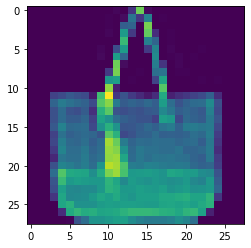

8


In [3]:
plt.imshow(train_imagesi[35,:,:])
plt.show()
print(train_labels[35])

In [4]:
train_labels[:100]

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9, 1, 0, 6, 4, 3, 1,
       4, 8, 4, 3, 0, 2, 4, 4, 5, 3, 6, 6, 0, 8, 5, 2, 1, 6, 6, 7, 9, 5,
       9, 2, 7, 3, 0, 3, 3, 3, 7, 2, 2, 6, 6, 8, 3, 3, 5, 0, 5, 5, 0, 2,
       0, 0, 4, 1, 3, 1, 6, 3, 1, 4, 4, 6, 1, 9, 1, 3, 5, 7, 9, 7, 1, 7,
       9, 9, 9, 3, 2, 9, 3, 6, 4, 1, 1, 8], dtype=uint8)

In [5]:
train_images[202,150:160]

array([-0.5984252 , -0.62204724, -0.64566929, -0.56692913, -0.59055118,
       -0.62992126, -0.61417323, -0.61417323, -0.66929134, -0.58267717])

In [6]:
# Размер набора данных для обучения
train_images.shape

(60000, 784)

## 1. Опишите - какой результата получен в нейросети в зависимости от:
## - числа нейронов в слое(для 2-хслойной сети),
## - числа слоев (2, 3, 5, 10) при близких размерах сети (близкое число тренируемых парметров).
## фиксируйте для тренировочного и тестового набора метрики accuracy.

In [7]:
#Собираем сеть по слоям через .add()
model = Sequential(name='2_layer_model')
model.add(Dense(128, activation='relu', input_shape=(784,)))  
# входной слой + поносвязный слой из 128 нейронов с активацией ReLU
model.add(Dense(10, activation='tanh')) 
# Скрытый слой 10 нейронов с активацией tanh
model.add(Dense(10, activation='softmax')) 
# выходной слой из 10 нейронов (сколько классов, столько нейронов) + активация softmax

# Компилируем сеть с оптимизатором Adam (нам на данный момент интересно влияние количества нейронов), функцией потерь и метрикой:
model.compile(
  optimizer='adam', # оптимизатор
  loss=keras.losses.CategoricalCrossentropy(), # функция потерь
  metrics=['accuracy'], # метрика
) 

2021-08-03 06:25:56.014861: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-08-03 06:25:56.014891: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-08-03 06:25:56.014916: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mitko-pc): /proc/driver/nvidia/version does not exist
2021-08-03 06:25:56.015128: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
model.summary()

Model: "2_layer_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
Total params: 101,880
Trainable params: 101,880
Non-trainable params: 0
_________________________________________________________________


**101 880** параметров в сети. Все будем обучать.

Как считать параметры слоя: (число входов нейрона +1)*число нейронов


Например, для 5 входов и 10 нейронов в слое - число настраиваемых параметров = (5+1)*10 = 60

In [9]:
# Превратим выходы в векторые (OHE в keras - from keras.utils import to_categorical)
train_labels[:5]

array([9, 0, 0, 3, 0], dtype=uint8)

In [10]:
y_t = to_categorical(train_labels)
y_tt = to_categorical(test_labels)
y_t[:3,:]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

#### Посмотрим на реакции модели до обучения.

In [11]:
train_labels[:5]

array([9, 0, 0, 3, 0], dtype=uint8)

In [12]:
y_pred = model.predict(test_images[:5,:])
y_pred[0,:].sum()

2021-08-03 06:25:56.338808: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-03 06:25:56.355970: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2099940000 Hz


1.0

In [13]:
y_class = np.argmax(y_pred, axis=1)
print(y_class)

[6 9 7 6 6]


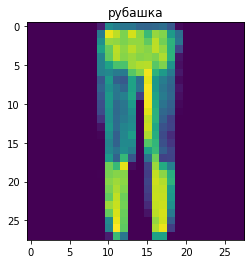

In [14]:
def encode_to_text(n):
    dict = {
        0: 'футболка',
        1: 'брюки',
        2: 'свитер',
        3: 'платье',
        4: 'куртка',
        5: 'сандалии',
        6: 'рубашка',
        7: 'кроссовки',
        8: 'сумка',
        9: 'ботинки',
            }
    return dict[n]
  
n = 3
plt.imshow(test_imagesi[n,:,:])
plt.title(encode_to_text(y_class[n]))
plt.show()

#### Сделаем цикл тренировки модели

In [15]:

# Train the model.
model.fit(  
  train_images[:,:],

  y_t[:,:],
  epochs=15,
  batch_size=32, validation_split=0.2
)

Epoch 1/15
1500/1500 [==============================] - 6s 1ms/step - loss: 0.8534 - accuracy: 0.7427 - val_loss: 0.5098 - val_accuracy: 0.8317
Epoch 2/15
1500/1500 [==============================] - 2s 1ms/step - loss: 0.4546 - accuracy: 0.8470 - val_loss: 0.4239 - val_accuracy: 0.8533
Epoch 3/15
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3916 - accuracy: 0.8657 - val_loss: 0.4118 - val_accuracy: 0.8597
Epoch 4/15
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3668 - accuracy: 0.8709 - val_loss: 0.4139 - val_accuracy: 0.8533
Epoch 5/15
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3401 - accuracy: 0.8798 - val_loss: 0.3781 - val_accuracy: 0.8695
Epoch 6/15
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3287 - accuracy: 0.8856 - val_loss: 0.3730 - val_accuracy: 0.8712
Epoch 7/15
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3126 - accuracy: 0.8908 - val_loss: 0.3869 - val_accuracy:

In [16]:
# Evaluate the model.
model.evaluate( 
  test_images,
  y_tt
)

# Predict on the first 5 test images.
predictions = model.predict(test_images[:5])

# Print our model's predictions.
y_predict = np.argmax(predictions, axis=1)
print(y_predict)

# Check our predictions against the ground truths.
print(test_labels[:5])

313/313 [==============================] - 0s 902us/step - loss: 0.3853 - accuracy: 0.8742
[9 2 1 1 6]
[9 2 1 1 6]


In [17]:
# Дополнительный цикл обучения
model.fit(
  train_images,
  y_t,
  epochs=3,
  batch_size=1024, validation_split=0.2, verbose=0
)

In [18]:
# сохранить веса модели.
# model.save_weights('model.h5')

# загрузить веса модели:
# model.load_weights('model.h5')

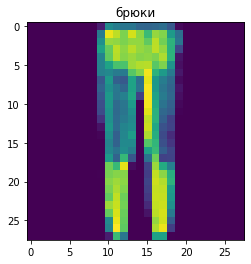

In [19]:
n = 3
plt.imshow(test_imagesi[n,:,:])
plt.title(encode_to_text(y_predict[n]))
plt.show()

### **Зависимость от числа нейронов в слое (для 2-хслойной сети)**

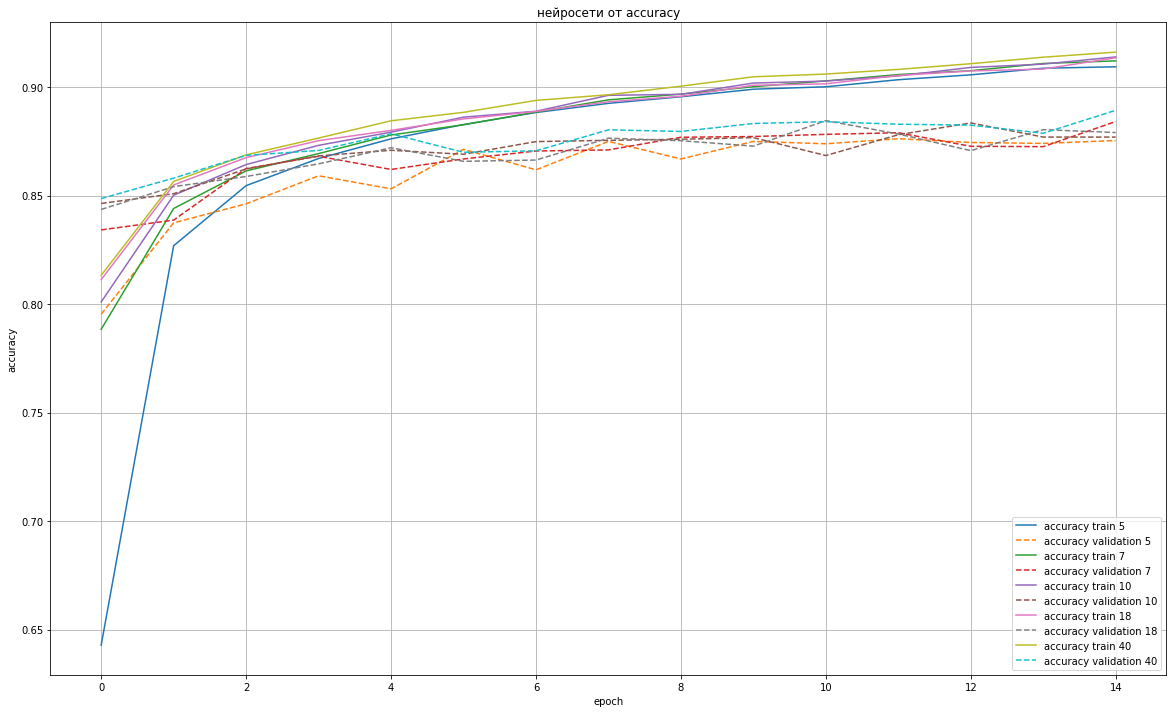

In [20]:
neuron_numb = [5, 7, 10, 18, 40]
plt.figure(figsize=(20,12))
for n in neuron_numb:
    model = Sequential(name='2_layer_model')
    model.add(Dense(128, activation='relu', input_shape=(784,)))  

    model.add(Dense(n, activation='tanh')) 

    model.add(Dense(10, activation='softmax')) 

    # Компилируем сеть с оптимизатором Adam (нам на данный момент интересно влияние количества нейронов), функцией потерь и метрикой:
    model.compile(
        optimizer='adam',
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy'],
    ) 
    model_history = model.fit(
        train_images[:,:],
        y_t[:,:],
        epochs=15,
        batch_size=32,
        validation_split=0.2,
        verbose=0
    )
#     model.evaluate(
#         test_images,
#         y_tt
#     )

#     predictions = model.predict(test_images[:5])

#     y_predict = np.argmax(predictions, axis=1)
    plt.plot(model_history.history['accuracy'], '-', label = f'accuracy train {n}')
    plt.plot(model_history.history['val_accuracy'], '--', label = f'accuracy validation {n}')
        
plt.legend()
plt.grid('On')
plt.title('нейросети от accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

### Вывод: качество нейронной сети не слишком зависит от числа нейронов без изменения числа слоев и при достаточном количестве эпох.

### **Зависимость от числа слоев (2, 3, 5, 10) при близких размерах сети (близкое число тренируемых парметров). Для того, чтобы число параметров было примерно одинаковым, возьмем в качестве neuron_numb константу, равную 30, а число нейронов в слое - число нейронов / число слоев.**

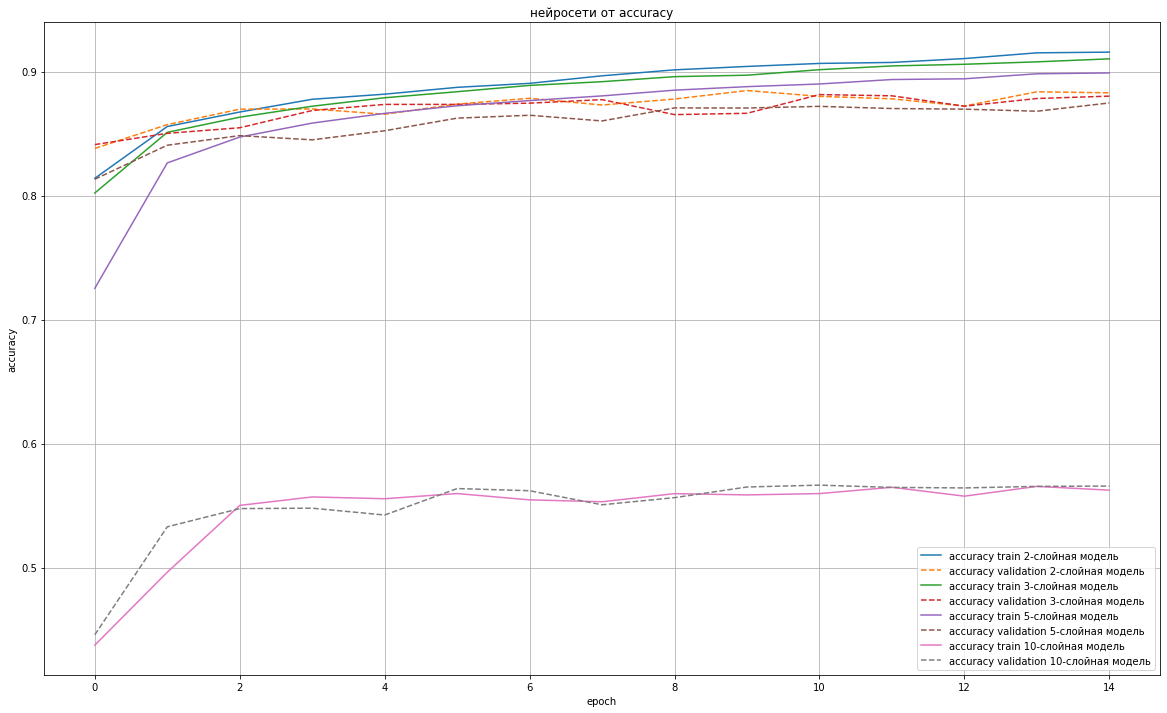

In [21]:
neuron_numb = 30
layers_numb = [2, 3, 5, 10]
plt.figure(figsize=(20,12))
for layers in layers_numb:
    model_l = Sequential(name=f'{layers}_layer_model')
    model_l.add(Dense(128, activation='relu', input_shape=(784,)))  

    for k in range(layers-1):
        model_l.add(Dense(neuron_numb / (layers-1), activation='tanh')) 

    model_l.add(Dense(10, activation='softmax'))
    
    if layers == 3:
        model_l.save_weights('model.l3') # сохраним для задания №2
#         print(model_l.summary())

    model_l.compile(
        optimizer='adam',
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy'],
    ) 
    model_l_history = model_l.fit(
        train_images[:,:],
        y_t[:,:],
        epochs=15,
        batch_size=32,
        validation_split=0.2,
        verbose=0
    )
    
    plt.plot(model_l_history.history['accuracy'], '-', label = f'accuracy train {layers}-слойная модель')
    plt.plot(model_l_history.history['val_accuracy'], '--', label = f'accuracy validation {layers}-слойная модель')
        
plt.legend()
plt.grid('On')
plt.title('нейросети от accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

### Вывод: большое количество слоев (при сравнимом числе тренируемых параметров) негативно влияет на качество сети.

## 2.  Проверьте работу разных оптимизаторов (SGD, Adam, RMSProp) для одной из моделей п.1.Фиксируйте для тренировочного и тестового набора метрики accuracy.

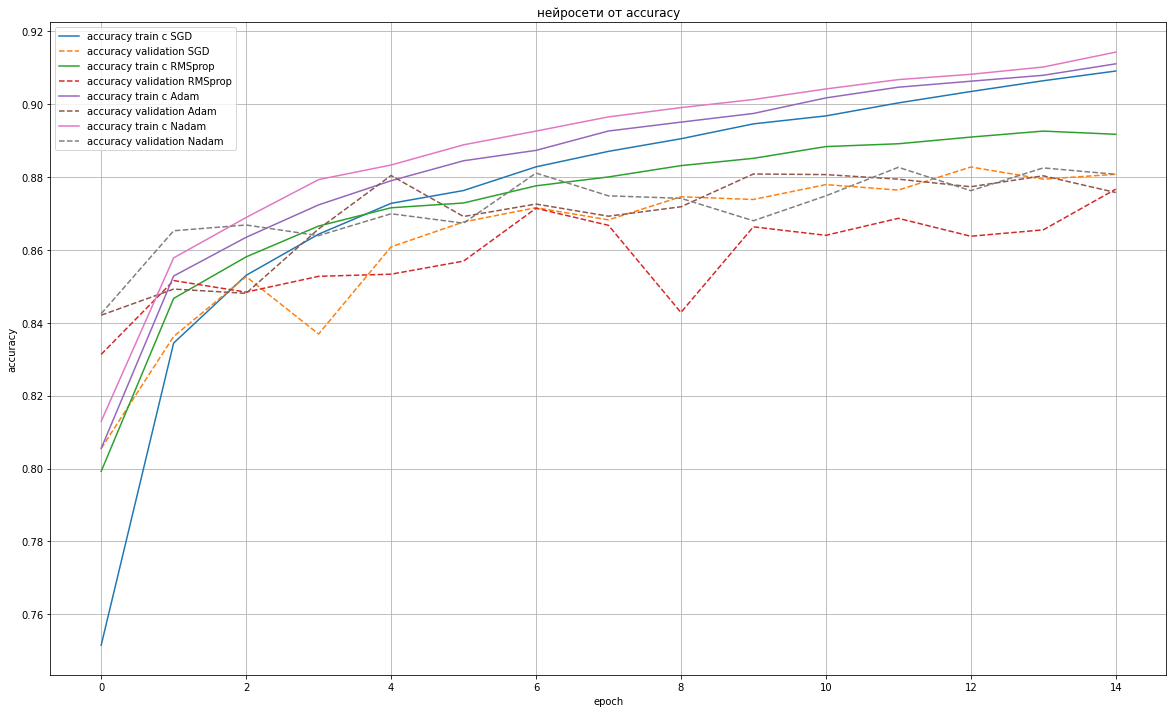

In [22]:
plt.figure(figsize=(20,12))

# число рабочих эпох
epochs = 15
# вектор для выводв результатов
epoch = np.arange(epochs+1)

for i_optim in [keras.optimizers.SGD(), keras.optimizers.RMSprop(), keras.optimizers.Adam(), keras.optimizers.Nadam()]:
  # создаем рабочую модель modeli куда будем загружать веса из предыдущего задания. Параметры сети - 3 слоя (2 скрытых по 15 нейронов)
    modeli = Sequential(name=f'{i_optim.get_config()["name"]}_layer_model')
    modeli.add(Dense(128, activation='relu', input_shape=(784,)))  

    for k in range(2):
        modeli.add(Dense(15, activation='tanh')) 

    modeli.add(Dense(10, activation='softmax'))
#     print(modeli.summary())
    
  # загружаем веса modeli.load_weights('model.h5')
    modeli.load_weights('model.l3')

  # компилируем modeli с одним из оптимизаторов
    modeli.compile(
        optimizer=i_optim,
        loss='categorical_crossentropy',
        metrics=['accuracy'],
        )

    modeli_history = modeli.fit(
                  train_images,
                  to_categorical(train_labels),
                  epochs=epochs,
                  batch_size=32, validation_split=0.2, verbose = 0
                  )

    plt.plot(modeli_history.history['accuracy'], '-', label = f'accuracy train с {modeli.optimizer.get_config()["name"]}')
    plt.plot(modeli_history.history['val_accuracy'], '--', label = f'accuracy validation {modeli.optimizer.get_config()["name"]}')
     
plt.legend()
plt.grid('On')
plt.title('нейросети от accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## 3. Сделайте вывод - что помогло вам улучшить качество классификации в нейросети на тестовом наборе?

### Качество сети на тестовом наборе помогает улучшить дообучение сети :)
### Если брать парамты, которые мы варьировали, то на нашем примере видно, что выбор оптимизатора не слишком влияет на качество сети, как и количество нейронов в двухслойной сети. А вот уменьшение количества слоев дает прибавку к качеству.

## 4. Для одного варианта сетей сформируйте матрицу ошибок по классам. Оцените качество модели по каждому классу отдельно (полнота , точность). Сделайте вывод.

In [23]:
neuron_numb = 20

model = Sequential(name='3_layer_model')
model.add(Dense(128, activation='relu', input_shape=(784,)))  
model.add(Dense(neuron_numb / 2, activation='tanh')) 
model.add(Dense(neuron_numb / 2, activation='tanh'))
model.add(Dense(10, activation='softmax')) 

model.compile(
  optimizer='nadam',
  loss=keras.losses.CategoricalCrossentropy(), # функция потерь
  metrics=['accuracy'],
) 

model.fit(  
    train_images[:,:],
    y_t[:,:],
    epochs=15,
    batch_size=32, validation_split=0.2, verbose=0
)

In [24]:
model.evaluate( 
  test_images,
  y_tt
)

predictions = model.predict(test_images)

y_predict = np.argmax(predictions, axis=1)
print(y_predict[:50])

print(test_labels[:50])

313/313 [==============================] - 0s 903us/step - loss: 0.3782 - accuracy: 0.8723
[9 2 1 1 6 1 4 6 5 7 4 5 7 3 4 1 2 2 8 0 2 5 7 5 1 2 6 0 9 3 8 8 3 3 8 0 7
 5 7 9 0 1 6 7 6 9 2 1 2 6]
[9 2 1 1 6 1 4 6 5 7 4 5 7 3 4 1 2 4 8 0 2 5 7 9 1 4 6 0 9 3 8 8 3 3 8 0 7
 5 7 9 6 1 3 7 6 7 2 1 2 2]


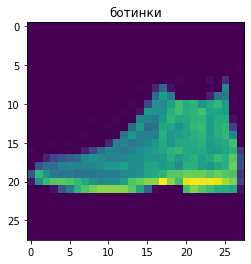

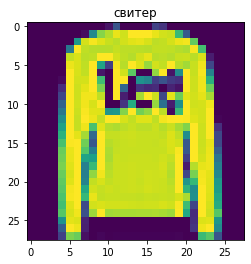

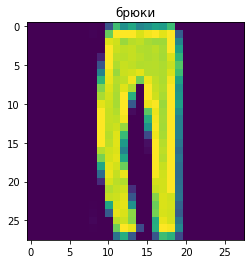

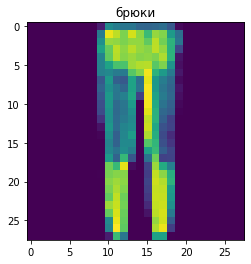

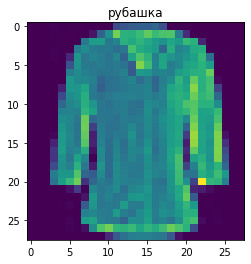

In [25]:
for n in range(5):
    plt.imshow(test_imagesi[n,:,:])
    plt.title(encode_to_text(y_predict[n]))
    plt.show()

In [26]:
# test_labels = pd.Series(test_labels, name='Actual')
# y_predict = pd.Series(y_predict, name='Predicted')
# df_confusion = pd.crosstab(test_labels, y_predict)
cnf_matrix = confusion_matrix(test_labels, y_predict)

In [27]:
cnf_matrix

array([[768,   0,   7,  24,   5,   1, 184,   0,  10,   1],
       [  1, 968,   2,  22,   3,   0,   2,   0,   2,   0],
       [  9,   1, 765,  13,  97,   1, 108,   0,   4,   2],
       [ 13,   9,   7, 905,  34,   0,  29,   0,   2,   1],
       [  0,   1,  89,  34, 812,   0,  58,   0,   6,   0],
       [  1,   0,   0,   0,   0, 925,   0,  35,   4,  35],
       [ 84,   2,  71,  31,  68,   2, 733,   0,   9,   0],
       [  0,   0,   0,   0,   0,  21,   0, 917,   1,  61],
       [  3,   0,   4,  12,   3,   3,  12,   2, 959,   2],
       [  0,   0,   1,   0,   0,   5,   0,  23,   0, 971]])

In [28]:
TP = np.diag(cnf_matrix)
TP

array([768, 968, 765, 905, 812, 925, 733, 917, 959, 971])

In [29]:
FP = np.sum(cnf_matrix, axis=0) - TP
FP

array([111,  13, 181, 136, 210,  33, 393,  60,  38, 102])

In [30]:
FN = np.sum(cnf_matrix, axis=1) - TP
FN

array([232,  32, 235,  95, 188,  75, 267,  83,  41,  29])

In [31]:
num_classes = 10
TN = []
for i in range(num_classes):
    temp = np.delete(cnf_matrix, i, 0)    # delete ith row
    temp = np.delete(temp, i, 1)  # delete ith column
    TN.append(sum(sum(temp)))
TN

[8889, 8987, 8819, 8864, 8790, 8967, 8607, 8940, 8962, 8898]

In [32]:
for i in range(num_classes):
    print(TP[i] + FP[i] + FN[i] + TN[i])

10000
10000
10000
10000
10000
10000
10000
10000
10000
10000


In [33]:
precision = TP/(TP+FP)
recall = TP/(TP+FN)
f = 2 * (precision * recall) / (precision + recall)

In [34]:
metrics = pd.DataFrame({'precision': precision, 'recall': recall, 'f1-score': f})

In [35]:
metrics

,precision,recall,f1-score
0,0.873720,0.768,0.817456
1,0.986748,0.968,0.977284
2,0.808668,0.765,0.786228
3,0.869356,0.905,0.886820
4,0.794521,0.812,0.803165
5,0.965553,0.925,0.944842
6,0.650977,0.733,0.689558
7,0.938588,0.917,0.927668
8,0.961886,0.959,0.960441
9,0.904939,0.971,0.936807


In [36]:
report = classification_report(test_labels, y_predict)
print(report)

              precision    recall  f1-score   support

           0       0.87      0.77      0.82      1000
           1       0.99      0.97      0.98      1000
           2       0.81      0.77      0.79      1000
           3       0.87      0.91      0.89      1000
           4       0.79      0.81      0.80      1000
           5       0.97      0.93      0.94      1000
           6       0.65      0.73      0.69      1000
           7       0.94      0.92      0.93      1000
           8       0.96      0.96      0.96      1000
           9       0.90      0.97      0.94      1000

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000



### Судя по метрикам, модель получилась достаточно хорошей. Проблема только с определением рубашек, но они и правда не очень четкие.